<a href="https://colab.research.google.com/github/malacosteus/MIPT/blob/main/ML/Lab2_DL_part2_overfitting_finv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [ ]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist is created!


In [ ]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting fmnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting fmnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting fmnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting fmnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw



In [ ]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [ ]:
len(fmnist_dataset_test)

10000

In [ ]:
for img, label in train_loader:
    print(img.shape)
#     print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [ ]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 450), nn.ReLU(), nn.BatchNorm1d(450),

            nn.Linear(450, 350), nn.ReLU(), nn.BatchNorm1d(350),

            nn.Linear(350, num_classes)
        )

    def forward(self, inp):       
        out = self.model(inp)
        return out

In [ ]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 450]         353,250
              ReLU-3                  [-1, 450]               0
       BatchNorm1d-4                  [-1, 450]             900
            Linear-5                  [-1, 350]         157,850
              ReLU-6                  [-1, 350]               0
       BatchNorm1d-7                  [-1, 350]             700
            Linear-8                   [-1, 10]           3,510
Total params: 516,210
Trainable params: 516,210
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 1.97
Estimated Total Size (MB): 2.00
----------------------------------------------------------------


Your experiments come here:

In [ ]:
model = TinyNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=5e-4)
loss_func = nn.CrossEntropyLoss()

# Your experiments, training and validation loops here

In [ ]:
from tqdm.auto import tqdm

def model_train_no_val(train_loader, model, opt, criterion, n_epoch):
    model.train()
    loss_train = []
    for i in tqdm(range(n_epoch)):
        loss_tmp = 0
        for input, label in train_loader:
            input = input.to(device)
            label = label.to(device)

            opt.zero_grad()

            preds = model(input)

            loss = criterion(preds, label)


            loss.backward()
            opt.step()

            loss_tmp += loss.item() * input.size(0)

        loss_train.append(loss_tmp)
    return  loss_train


def model_train_val(train_loader, val_loader, model, opt, criterion, n_epoch):
    loss_train = []
    loss_val = []
    for i in tqdm(range(n_epoch)):
        loss_train_tmp = 0
        for input, label in train_loader:
            model.train()

            input = input.to(device)
            label = label.to(device)

            opt.zero_grad()
            preds = model(input)

            loss = criterion(preds, label)

            loss.backward()
            opt.step()

            loss_train_tmp += loss.item() * input.size(0)

            model.eval()
            loss_val_tmp = 0
            with torch.no_grad():
                for input, label in val_loader:
                    input = input.to(device)
                    label = label.to(device)

                    preds = model(input)
                    loss = criterion(preds, label)

                    loss_val_tmp += loss.item() * input.size(0)

        loss_train.append(loss_train_tmp)
        loss_val.append(loss_val_tmp)

    return  loss_train, loss_val

In [ ]:
def plt1(loss):
    plt.figure(figsize = (10 , 10))
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    plt.plot(np.arange(len(loss)) + 1, loss, label="Training loss")

    plt.legend()
    plt.show()

def plt2(loss_train, loss_val):
    plt.figure(figsize = (10 , 10))
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    plt.plot(np.arange(len(loss_train)) + 1, loss_train, label="Training loss")
    plt.plot(np.arange(len(loss_val)) + 1, loss_val, label="Validation loss")

    plt.legend()
    plt.show()


def eval_model(model, test_loader):
    res = 0

    model.eval()
    with torch.no_grad():
        for input, label in test_loader:

            input = input.to(device)
            label_cuda = label.to(device)

            outputs = model.forward(input)
            preds = torch.argmax(outputs, dim = 1)

            res += torch.sum(preds == label_cuda.data).item()
    print(res / len(test_loader.dataset))

In [ ]:
loss_train = model_train_no_val(train_loader, model, opt, loss_func, 23)

  0%|          | 0/23 [00:00<?, ?it/s]

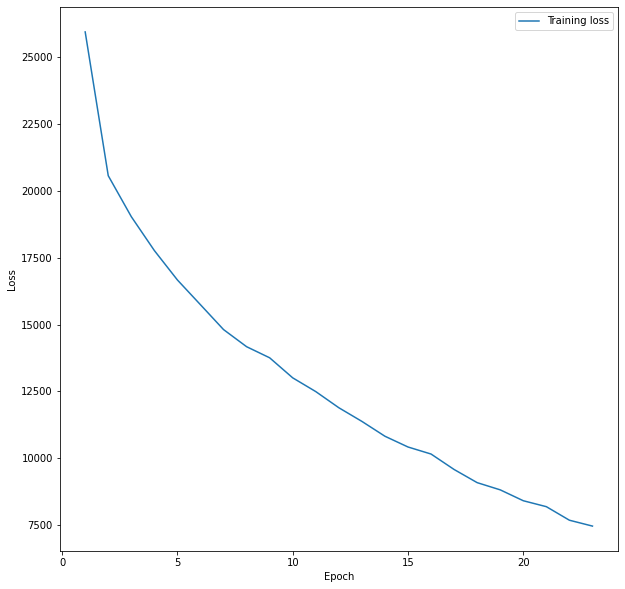

In [ ]:
plt1(loss_train)

In [ ]:
eval_model(model, test_loader)

0.8912


**Required accuracy is achieved**

### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [ ]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 2300), nn.ReLU(),

            nn.Linear(2300, 1500), nn.ReLU(),

            nn.Linear(1500, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [ ]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                 [-1, 2300]       1,805,500
              ReLU-3                 [-1, 2300]               0
            Linear-4                 [-1, 1500]       3,451,500
              ReLU-5                 [-1, 1500]               0
            Linear-6                   [-1, 10]          15,010
Total params: 5,272,010
Trainable params: 5,272,010
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 20.11
Estimated Total Size (MB): 20.18
----------------------------------------------------------------


In [ ]:
fmnist_dataset_train_extract, fmnist_dataset_val_extract, fake = torch.utils.data.dataset.random_split(
    fmnist_dataset_train, [1115, 1115,  len(fmnist_dataset_train) - 2230])

tr_loader = torch.utils.data.DataLoader(fmnist_dataset_train_extract, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
vl_loader = torch.utils.data.DataLoader(fmnist_dataset_val_extract, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)

In [ ]:
model = OverfittingNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=5e-4)
loss_func = nn.CrossEntropyLoss()

# Your experiments, come here
loss_train, loss_val = model_train_val(tr_loader, vl_loader, model, opt, loss_func, 23)

  0%|          | 0/23 [00:00<?, ?it/s]

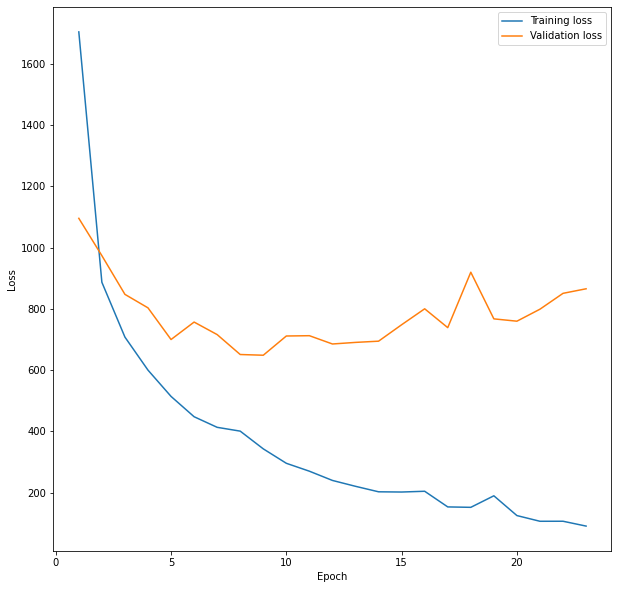

In [ ]:
plt2(loss_train, loss_val)

**We can see that although our train loss is improving with increase in number of epoch our validarion loss is getting worse and worse**

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [ ]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, 2300), nn.Dropout(p = 0.8), nn.ReLU(), nn.BatchNorm1d(2300),

            nn.Linear(2300, 1500), nn.Dropout(p = 0.8), nn.ReLU(), nn.BatchNorm1d(1500),

            nn.Linear(1500, num_classes),
        )
        
    def forward(self, inp):
        out = self.model(inp)
        return out

In [ ]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                 [-1, 2300]       1,805,500
           Dropout-3                 [-1, 2300]               0
              ReLU-4                 [-1, 2300]               0
       BatchNorm1d-5                 [-1, 2300]           4,600
            Linear-6                 [-1, 1500]       3,451,500
           Dropout-7                 [-1, 1500]               0
              ReLU-8                 [-1, 1500]               0
       BatchNorm1d-9                 [-1, 1500]           3,000
           Linear-10                   [-1, 10]          15,010
Total params: 5,279,610
Trainable params: 5,279,610
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.12
Params size (MB): 20.14
Estima

In [ ]:
model = FixedNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=5e-4)
loss_func = nn.CrossEntropyLoss()

# Your experiments, come here
loss_train, loss_val = model_train_val(tr_loader, vl_loader, model, opt, loss_func, 63)

  0%|          | 0/63 [00:00<?, ?it/s]

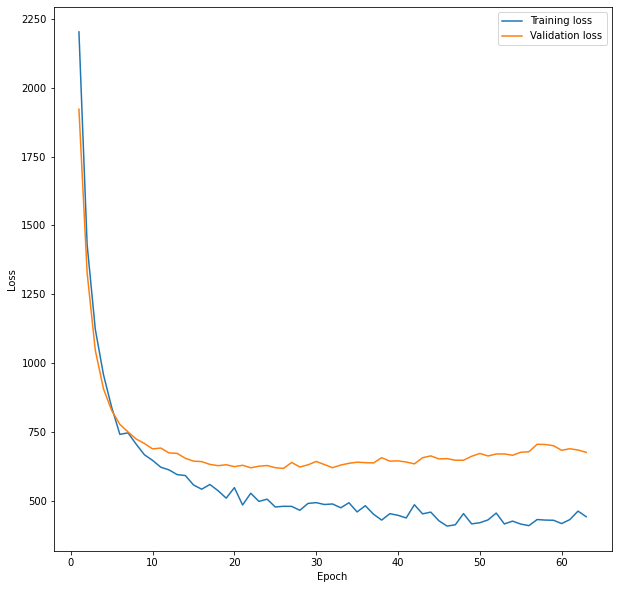

In [ ]:
plt2(loss_train, loss_val)

**We can see that droupout helped us  and now our validation loss is improving with number of epochs**

### Conclusions:

We see that if NN has too many parameters we can easily get overfitted model, which can't give us good results.
Droupout layers, batch normalization and other methods can help with that. But even with them we can get worse results compared to model with adequate number of parameters. In Task 3 our validation loss became better because of dropout layers and normalization, but it still diverges from training loss with increase in numbers of epochs.
In Task 2 our validation loss is > 800. In Task 3 our validation loss is < 750 because of dropout layers and batch normalization.

On the other side in Task 1 we have small number of parameters and we can get good performance even without dropout layers. So, it's a good idea to always think about number of parmeters of our model, check it for overfitting and search for good number of parameters and ight architecture instead of building huge overfitted model.